Upload your kaggle.json file here...


Saving kaggle.json to kaggle.json
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./titanic_data/titanic.zip
  inflating: ./titanic_data/gender_submission.csv  
  inflating: ./titanic_data/test.csv  
  inflating: ./titanic_data/train.csv  
Train shape: (891, 12)
Test shape: (418, 11)


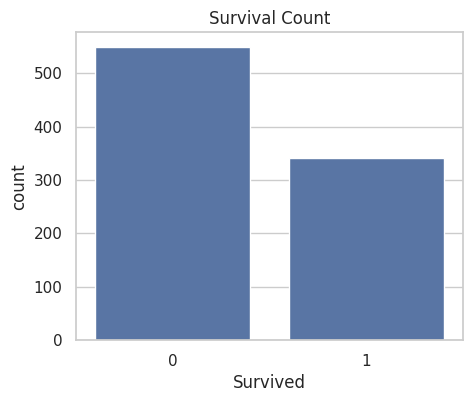

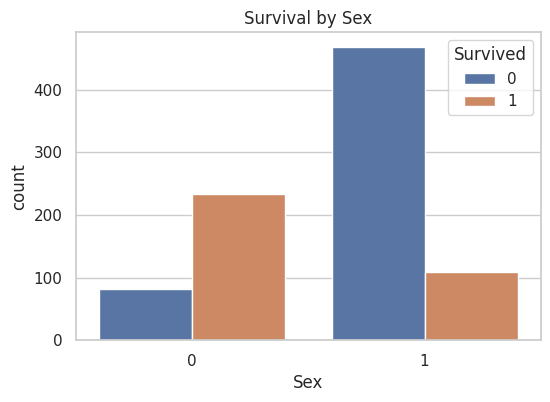

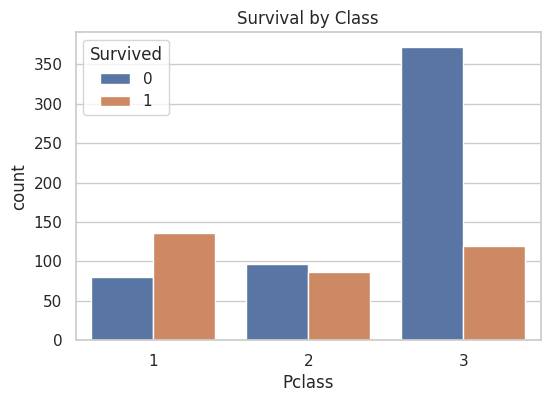

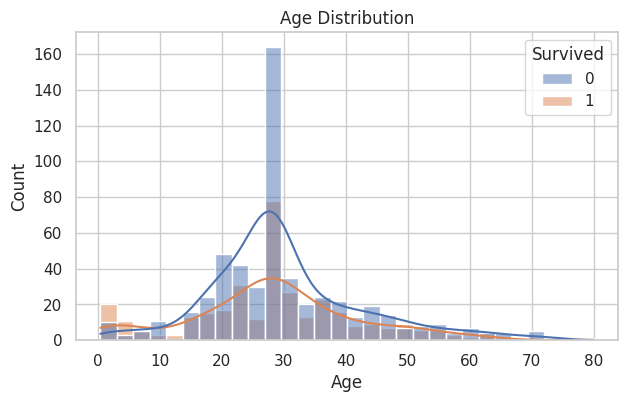

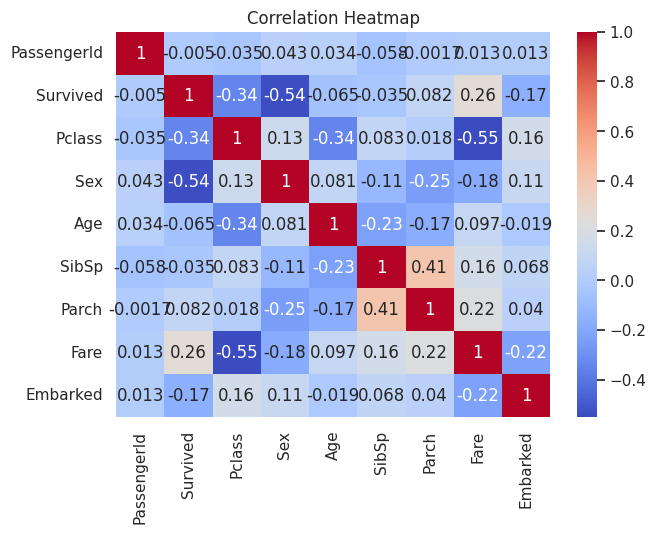


Training different models...

Logistic Regression: 0.7989
SVM: 0.8156
Decision Tree: 0.8324
KNN: 0.8101
Random Forest: 0.8101
XGBoost: 0.8101

Model Comparison:

                 Model  Accuracy
2        Decision Tree  0.832402
1                  SVM  0.815642
4        Random Forest  0.810056
3                  KNN  0.810056
5              XGBoost  0.810056
0  Logistic Regression  0.798883


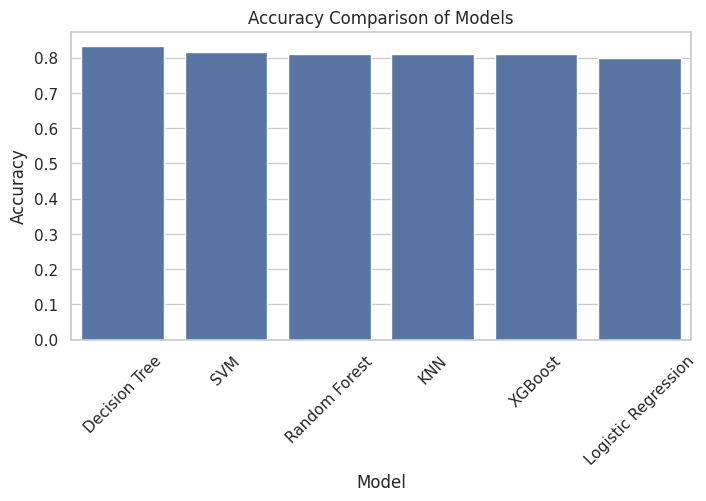


Best Model: Decision Tree

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



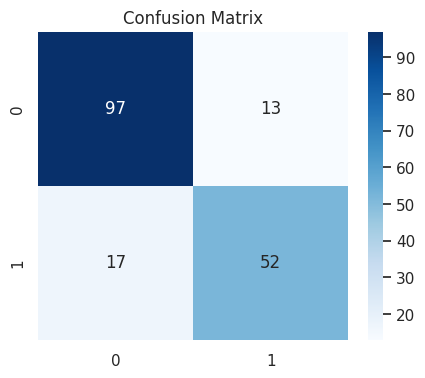

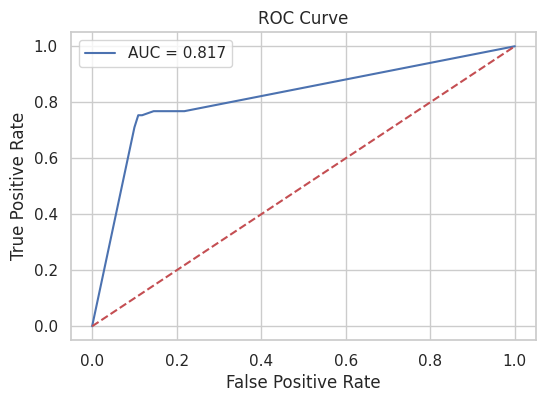


Sample Passenger Prediction:
Passenger would NOT have survived.


In [ ]:

# ================================================================
# TITANIC SURVIVAL PREDICTION PROJECT – CODSOFT INTERNSHIP
# ================================================================

# I am installing the kaggle package so I can download the dataset directly.
!pip install -q kaggle xgboost

# ------------------------------------------------------------
# STEP 1: Upload kaggle.json and download the Titanic dataset
# ------------------------------------------------------------
import os
from google.colab import files

# Creating the directory where kaggle.json will be stored
os.makedirs("/root/.kaggle/", exist_ok=True)

print("Upload your kaggle.json file here...")
uploaded = files.upload()   # I manually upload my Kaggle API token

# Move kaggle.json to correct path and give permissions
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Using Kaggle API to download the Titanic dataset
!kaggle competitions download -c titanic -p ./titanic_data

# Unzipping the dataset
!unzip -o ./titanic_data/titanic.zip -d ./titanic_data

# ------------------------------------------------------------
# STEP 2: Importing all required libraries
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML-related imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Setting seaborn theme for better plots
sns.set(style="whitegrid")

# ------------------------------------------------------------
# STEP 3: Loading the dataset
# ------------------------------------------------------------
train = pd.read_csv("/content/titanic_data/train.csv")
test = pd.read_csv("/content/titanic_data/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# I will work on copied dataframes to avoid warnings
train = train.copy()
test = test.copy()

# ------------------------------------------------------------
# STEP 4: Handling missing values
# ------------------------------------------------------------

# Filling Age missing values with median age
train["Age"] = train["Age"].fillna(train["Age"].median())
test["Age"] = test["Age"].fillna(test["Age"].median())

# Filling Embarked missing values with most frequent port
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])
test["Embarked"] = test["Embarked"].fillna(test["Embarked"].mode()[0])

# Filling missing Fare in test with its median
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

# Cabin column has too many missing values, so I dropped it
train = train.drop(columns=["Cabin"])
test = test.drop(columns=["Cabin"])

# ------------------------------------------------------------
# STEP 5: Encoding categorical columns
# ------------------------------------------------------------

# Label encoding Sex column (male/female → 0/1)
le_sex = LabelEncoder()
train["Sex"] = le_sex.fit_transform(train["Sex"])
test["Sex"] = le_sex.transform(test["Sex"])

# Label encoding Embarked column (C/Q/S → 0/1/2)
le_emb = LabelEncoder()
train["Embarked"] = le_emb.fit_transform(train["Embarked"])
test["Embarked"] = le_emb.transform(test["Embarked"])

# ------------------------------------------------------------
# STEP 6: Exploratory Data Analysis (EDA)
# ------------------------------------------------------------

# Plotting how many survived and how many didn’t
plt.figure(figsize=(5,4))
sns.countplot(data=train, x="Survived")
plt.title("Survival Count")
plt.show()

# Checking survival based on gender
plt.figure(figsize=(6,4))
sns.countplot(data=train, x="Sex", hue="Survived")
plt.title("Survival by Sex")
plt.show()

# Survival based on passenger class
plt.figure(figsize=(6,4))
sns.countplot(data=train, x="Pclass", hue="Survived")
plt.title("Survival by Class")
plt.show()

# Age distribution with respect to survival
plt.figure(figsize=(7,4))
sns.histplot(data=train, x="Age", hue="Survived", kde=True)
plt.title("Age Distribution")
plt.show()

# Correlation heatmap for numeric columns only
numeric_cols = train.select_dtypes(include=[np.number])
plt.figure(figsize=(7,5))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# ------------------------------------------------------------
# STEP 7: Preparing features and scaling
# ------------------------------------------------------------

# These are the columns I will use to train the model
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

X = train[features]
y = train["Survived"]

# Scaling features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------------------------------------
# STEP 8: Training multiple ML models
# ------------------------------------------------------------

models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results = {}

print("\nTraining different models...\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

# ------------------------------------------------------------
# STEP 9: Comparing model performance
# ------------------------------------------------------------

results_df = pd.DataFrame(results.items(), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("\nModel Comparison:\n")
print(results_df)

plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.title("Accuracy Comparison of Models")
plt.xticks(rotation=45)
plt.show()

# Getting the best model
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

print("\nBest Model:", best_model_name)

# ------------------------------------------------------------
# STEP 10: Evaluating the best model
# ------------------------------------------------------------

y_pred = best_model.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC Curve
if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# ------------------------------------------------------------
# STEP 11: Making a sample prediction
# ------------------------------------------------------------

sample = pd.DataFrame([[3, 1, 22, 0, 0, 7.25, 2]], columns=features)
sample_scaled = scaler.transform(sample)

sample_pred = best_model.predict(sample_scaled)[0]

print("\nSample Passenger Prediction:")
if sample_pred == 1:
    print("Passenger would have SURVIVED.")
else:
    print("Passenger would NOT have survived.")
